## 테이블의 내용은 아래의 내용을 담고 있습니다.
1. 고객이 각 귀속년도별
1. 근로 / 사업 / 기타 소득에 대한 예상환급액과 수수료를 조회한 뒤
1. 결제를 하거나 하지 않은 여부를 저장

## 컬럼 정보는 다음과 같습니다.
- age: 고객의 만 나이입니다. 
- gender: 고객의 성별입니다.
- year: 소득이 발생한 연도(귀속년도)입니다.
- refund: 예상환급액입니다.
- fee: 수수료입니다.
- has_paid: 수수료를 결제했는지의 여부
- income_근로: 고객의 근로소득(월급/일용직급여)
- income_사업: 고객의 사업소득(프리랜서 소득)
- income_기타: 고객의 기타소득(그외 기타 소득)

## 아래의 질문에 나름의 방식으로 답을 찾아주세요.
(정답은 없습니다. 문제를 정의하고, 해답에 이르게 된 과정과 그 해석을 잘 설득/설명해 주시는 것이 중요합니다.)

- 고객의 결제여부에 영향을 미치는 요인들은 무엇인가요? 
- 고객의 수수료 결제금액의 합을 높히기 위해서는 어떻게 해야 할까요?

# 라이브러리 

In [151]:
import pandas as pd
pd.options.display.float_format = '{:.0f}'.format

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf


# 경고 무시
import warnings
warnings.filterwarnings('ignore')

<AxesSubplot:title={'center':'한글폰트'}>

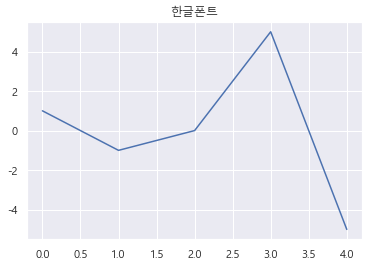

In [79]:
## 시각화를 위한 폰트설정
# (Windows OS) 한글 출력을 위한 글꼴 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  
  
# 문자 - (마이너스) 정상 출력을 위한 코드
plt.rcParams['axes.unicode_minus'] = False

sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

# 데이터 로드

In [3]:
df = pd.read_csv('C:/Users/s/Desktop/wanted_onboarding/Jobis_3o3.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   age        100000 non-null  float64
 1   gender     100000 non-null  object 
 2   year       100000 non-null  int64  
 3   refund     100000 non-null  float64
 4   fee        100000 non-null  float64
 5   has_paid   100000 non-null  bool   
 6   income_근로  40791 non-null   float64
 7   income_사업  78227 non-null   float64
 8   income_기타  25260 non-null   float64
dtypes: bool(1), float64(6), int64(1), object(1)
memory usage: 6.2+ MB


In [5]:
df.describe()

,age,year,refund,fee,income_근로,income_사업,income_기타
count,100000,100000,100000,100000,40791,78227,25260
mean,29,2018,208142,7248,6432597,1511712,636283
std,8,1,307174,11927,6583716,2449810,1484947
min,15,2015,-8265000,400,0,0,0
25%,24,2017,33000,400,1616000,177000,82000
50%,27,2018,99000,4300,4507000,619000,213000
75%,31,2019,254000,8500,9301000,1601000,582000
max,81,2020,7725000,307000,182335000,39934000,62810000


In [6]:
# 결측값 0으로 대체하기
df = df.fillna(0)

In [7]:
# (근로+사업)소득, (사업+기타)소득, (기타+근로)소득, 총소득 column 추가
df['income_근로_사업'] = df['income_근로']+df['income_사업']
df['income_사업_기타'] = df['income_사업']+df['income_기타']
df['income_기타_근로'] = df['income_기타']+df['income_근로']
df['total_income'] = df['income_근로']+df['income_사업']+df['income_기타']
df = df.sort_values(['total_income'], ascending = False)
df

,age,gender,year,refund,fee,has_paid,income_근로,income_사업,income_기타,income_근로_사업,income_사업_기타,income_기타_근로,total_income
51302,53,M,2015,262000,8500,True,182335000,1581000,2729000,183916000,4310000,185064000,186645000
83615,53,M,2016,219000,8500,True,170864000,1319000,1445000,172183000,2764000,172309000,173628000
82775,53,M,2020,373000,14500,False,164883000,220000,1617000,165103000,1837000,166500000,166720000
16756,51,M,2018,65000,400,True,136176000,389000,0,136565000,389000,136176000,136565000
80814,40,M,2019,228000,8900,False,107272000,213000,638000,107485000,851000,107910000,108123000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64151,48,F,2015,31000,400,False,0,0,0,0,0,0,0
89974,27,F,2018,75000,2100,False,0,0,0,0,0,0,0
89975,28,M,2017,146000,4300,False,0,0,0,0,0,0,0
64146,20,M,2017,27000,400,True,0,0,0,0,0,0,0


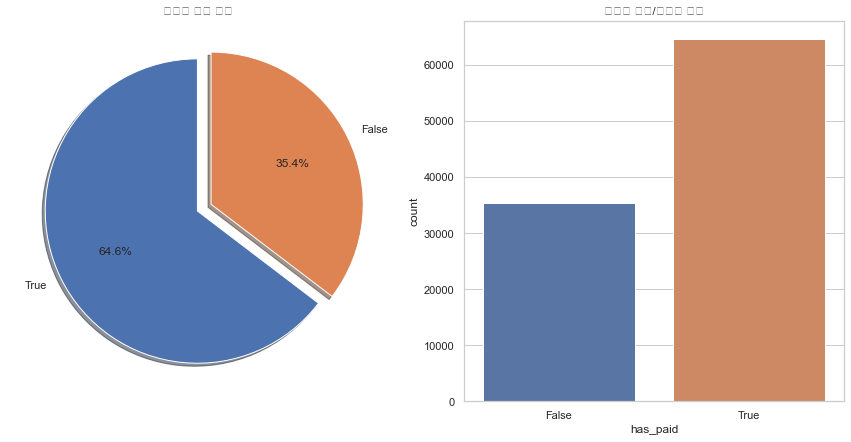

In [80]:
# 수수료 결제, 미결제 분포 확인
sns.set(style='whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(15,7))
df['has_paid'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%',ax=ax[0],shadow=True,startangle=90)
ax[0].set_title('수수료 결제 비율') # 파이 그래프 이름
ax[0].set_ylabel('') # 파이 그래프

sns.countplot('has_paid', data=df, ax=ax[1])# countplot : 각 카테고리 값별로 데이터가 얼마나 있는지 표시 / countplot(x='column_name', data=dataframe)
ax[1].set_title('수수료 결제/미결제 횟수')
plt.show() # 막대 그래프

# 상관 분석(Correlation Analysis)

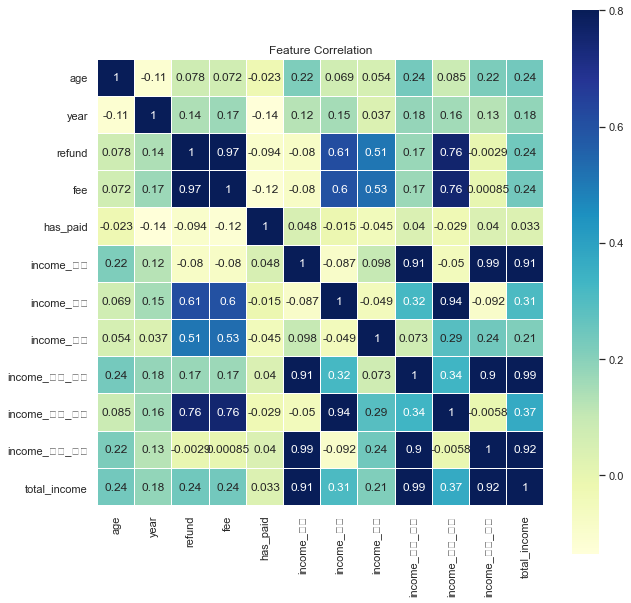

In [9]:
corr = df.corr()
plt.figure(figsize=(10, 10));
sns.heatmap(corr,
            vmax=0.8,
            linewidths=0.01,
            square=True,
            annot=True,
            cmap='YlGnBu');
plt.title('Feature Correlation');

In [82]:
useful_feature_list = corr.query("has_paid > 0.04 or has_paid < -0.04").index.values.tolist()
useful_feature_list.remove('has_paid')
print(useful_feature_list)

['year', 'refund', 'fee', 'income_근로', 'income_기타', 'income_기타_근로']


> 수수료 결제 여부와 다른 요소들 간에 연관관계가 거의 없는 것으로 보인다. 그나마 수수료가 -0.12로 미세하게 역의 상관관계가 있으나, 이는 년도와의 -0.14 상관관계보다 낮은 수치기 때문에 유의미한 연관관계는 없다고 볼 수 있다.

In [83]:
full_column_list = df.columns.to_list()
full_column_list.remove('has_paid')
full_column_list.remove('gender')
full_column_list

['age',
 'year',
 'refund',
 'fee',
 'income_근로',
 'income_사업',
 'income_기타',
 'income_근로_사업',
 'income_사업_기타',
 'income_기타_근로',
 'total_income']

In [84]:
len(full_column_list)

11

In [13]:
# 범주형 변수를 더미 변수로 전환
df2 = pd.get_dummies(df,columns=['gender','has_paid'])

In [14]:
# 필요없는 column drop
df2.drop('gender_-', axis=1, inplace=True)
df2

,age,year,refund,fee,income_근로,income_사업,income_기타,income_근로_사업,income_사업_기타,income_기타_근로,total_income,gender_F,gender_M,has_paid_False,has_paid_True
51302,53,2015,262000,8500,182335000,1581000,2729000,183916000,4310000,185064000,186645000,0,1,0,1
83615,53,2016,219000,8500,170864000,1319000,1445000,172183000,2764000,172309000,173628000,0,1,0,1
82775,53,2020,373000,14500,164883000,220000,1617000,165103000,1837000,166500000,166720000,0,1,1,0
16756,51,2018,65000,400,136176000,389000,0,136565000,389000,136176000,136565000,0,1,0,1
80814,40,2019,228000,8900,107272000,213000,638000,107485000,851000,107910000,108123000,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64151,48,2015,31000,400,0,0,0,0,0,0,0,1,0,1,0
89974,27,2018,75000,2100,0,0,0,0,0,0,0,1,0,1,0
89975,28,2017,146000,4300,0,0,0,0,0,0,0,0,1,1,0
64146,20,2017,27000,400,0,0,0,0,0,0,0,0,1,0,1


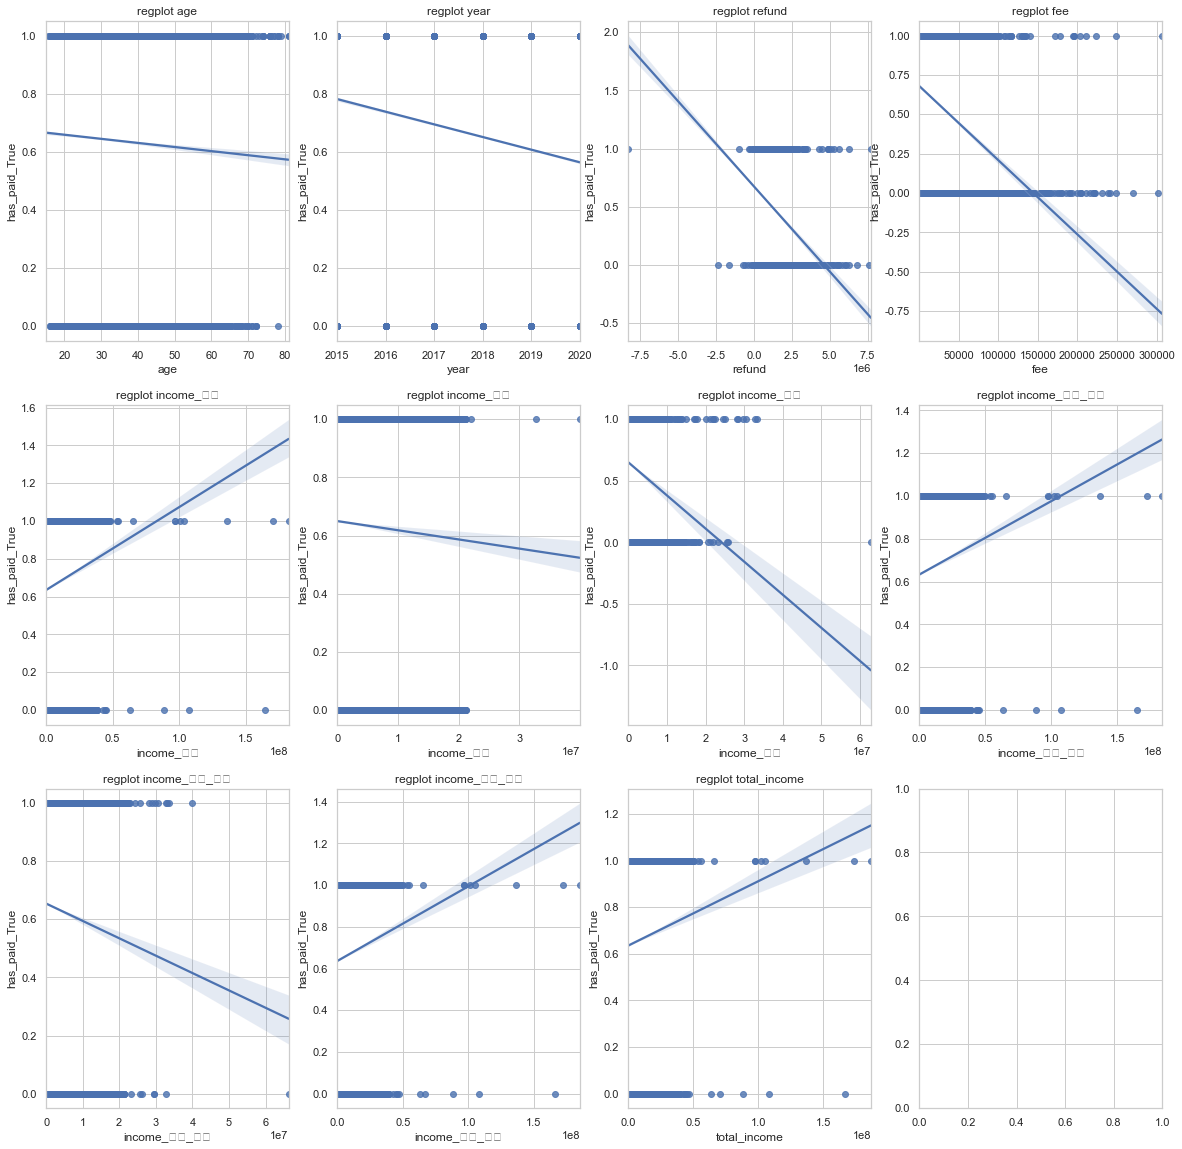

In [15]:
# 수수료 결제와 다른 항목들 간의 관계를 regression plot을 통해 시각화
figure, ax_list = plt.subplots(nrows=3, ncols=4)
figure.set_size_inches(20,20) 
for i in range(len(full_column_list)): 
    sns.regplot(data=df2, x=full_column_list[i], y='has_paid_True', ax=ax_list[int(i/4)][int(i%4)]) 
    ax_list[int(i/4)][int(i%4)].set_title("regplot " + full_column_list[i])

> * 수수료가 증가함에 따라 수수료 결제를 하지 않는 경향이 있다.

# 수수료 결제 여부 예측 모델

In [111]:
df2.describe()

,age,year,refund,fee,income_근로,income_사업,income_기타,income_근로_사업,income_사업_기타,income_기타_근로,total_income,gender_F,gender_M,has_paid_False,has_paid_True,profit
count,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
mean,29,2018,208142,7248,2623921,1182567,160725,3806488,1343292,2784646,3967213,0,1,0,1,4014
std,8,1,307174,11927,5260655,2254789,795876,5540687,2354015,5397119,5654866,0,0,0,0,8289
min,15,2015,-8265000,400,0,0,0,0,0,0,0,0,0,0,0,0
25%,24,2017,33000,400,0,31000,0,153000,118000,0,261000,0,0,0,0,0
50%,27,2018,99000,4300,0,328000,0,1279000,480000,45000,1440000,0,1,0,1,400
75%,31,2019,254000,8500,2994000,1235000,2000,5641000,1433000,3279250,5805250,1,1,1,1,4300
max,81,2020,7725000,307000,182335000,39934000,62810000,183916000,66319000,185064000,186645000,1,1,1,1,307000


## WMAE 손실함수 정의
* 수수료 결제여부에 미치는 영향이 비교적 큰 수수료의 상위 25% 기준이 되는 8500 이상일 경우 가중치를 부여
> * 가중치 3; WMAE:62.71, accuracy: 61.575
> * 가중치 5; WMAE:60.97, accuracy: 62.08
> * 가중치 10; WMAE:60.82, accuracy: 62.21
> * 가중치 15; WMAE:61.04, accuracy: 62.045
> * 가중치 20; WMAE:60.52, accuracy: 61.755
> * 가중치 25; WMAE:60.65, accuracy: 61.53

In [299]:
def WMAE(dataset, real, predicted):
    weights = dataset.fee.apply(lambda x: 20 if x>8500 else 1)
    
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

## training data 준비

In [300]:
X_train = df2[['refund', 'fee', 'income_근로', 'income_기타', 'income_기타_근로']]
Y_train = df2['has_paid_True']

## Random Forest Estimator 선언 후 학습 및 예측

In [301]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score # 정확도 함수

In [302]:
# 학습 & 예측 데이터 나누기
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2)
# 학습 진행
RFC = RandomForestClassifier(n_estimators=30, max_depth=100)
RFC.fit(x_train, y_train)
# 예측
predicted = RFC.predict(x_test)
print(predicted)

[1 0 1 ... 1 0 0]


## training error 측정

In [303]:
print('WMAE :', WMAE(x_test, y_test, predicted))

WMAE : 60.52


## test data에 대한 예측 수행

In [304]:
X_test = train_detail[['refund', 'fee', 'income_근로', 'income_기타', 'income_기타_근로']]
predict = RF.predict(X_test)
print(predict)
print(accuracy_score(y_test,predicted))

[1 1 0 ... 1 1 1]
0.61755


# 회사 수익

In [16]:
# 회사 수익(=수수료*결제여부) 항목 추가
df2['profit'] = df2['fee']*df2['has_paid_True']
# 회사 수익이 플러스인 행들만 남기기
df3 = df2.loc[df2['profit']>0]
df3.sort_values('profit', ascending=False)

,age,year,refund,fee,income_근로,income_사업,income_기타,income_근로_사업,income_사업_기타,income_기타_근로,total_income,gender_F,gender_M,has_paid_False,has_paid_True,profit
61745,25,2018,7725000,307000,2850000,0,17297000,2850000,17297000,20147000,20147000,1,0,0,1,307000
30513,32,2017,6254000,248300,0,0,10918000,0,10918000,10918000,10918000,1,0,0,1,248300
87274,51,2020,5620000,223200,0,0,21093000,0,21093000,21093000,21093000,0,1,0,1,223200
87287,40,2018,5312000,210900,8029000,0,12755000,8029000,12755000,20784000,20784000,1,0,0,1,210900
50214,50,2020,5119000,203200,0,1958000,17702000,1958000,19660000,17702000,19660000,0,1,0,1,203200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34165,27,2019,21000,400,0,128000,425000,128000,553000,425000,553000,0,1,0,1,400
49974,29,2019,30000,400,14402000,0,85000,14402000,85000,14487000,14487000,0,1,0,1,400
39680,33,2019,25000,400,14336000,150000,0,14486000,150000,14336000,14486000,0,1,0,1,400
63160,34,2017,20000,400,14366000,119000,0,14485000,119000,14366000,14485000,1,0,0,1,400


In [17]:
df3.describe()

,age,year,refund,fee,income_근로,income_사업,income_기타,income_근로_사업,income_사업_기타,income_기타_근로,total_income,gender_F,gender_M,has_paid_False,has_paid_True,profit
count,64643,64643,64643,64643,64643,64643,64643,64643,64643,64643,64643,64643,64643,64643,64643,64643
mean,29,2018,186774,6209,2811628,1157692,134355,3969320,1292047,2945983,4103675,0,1,0,1,6209
std,8,1,256671,9626,5387821,2066087,652377,5602952,2133107,5502463,5700648,0,0,0,0,9626
min,15,2015,-8265000,400,0,0,0,0,0,0,0,0,0,0,1,400
25%,24,2017,34000,400,0,85000,0,299000,174000,0,395000,0,0,0,1,400
50%,27,2018,94000,3000,0,422000,0,1450000,548000,128000,1566000,0,1,0,1,3000
75%,31,2019,232000,8500,3567000,1262000,11000,5877000,1405000,3735500,5986000,1,1,0,1,8500
max,81,2020,7725000,307000,182335000,39934000,33235000,183916000,39934000,185064000,186645000,1,1,0,1,307000


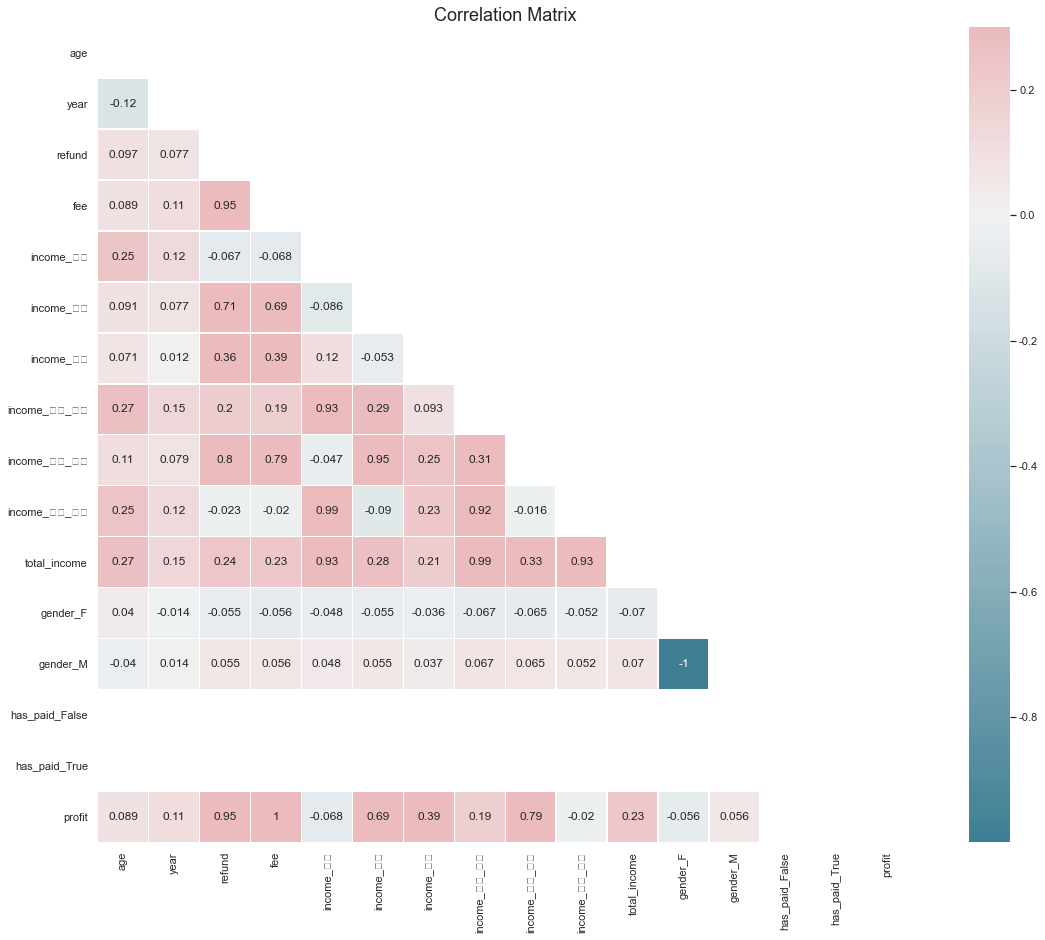

In [18]:
# 회사 수익과 상관관계가 높은 항목을 찾기 위한 Correlation Matrix
sns.set(style="white")
corr2 = df3.corr()
mask = np.triu(np.ones_like(corr2, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True)
plt.show()

In [51]:
full_column_list2 = df3.columns.to_list()
full_column_list2.remove('profit')
full_column_list2

['age',
 'year',
 'refund',
 'fee',
 'income_근로',
 'income_사업',
 'income_기타',
 'income_근로_사업',
 'income_사업_기타',
 'income_기타_근로',
 'total_income',
 'gender_F',
 'gender_M',
 'has_paid_False',
 'has_paid_True']

In [52]:
len(full_column_list2)

15

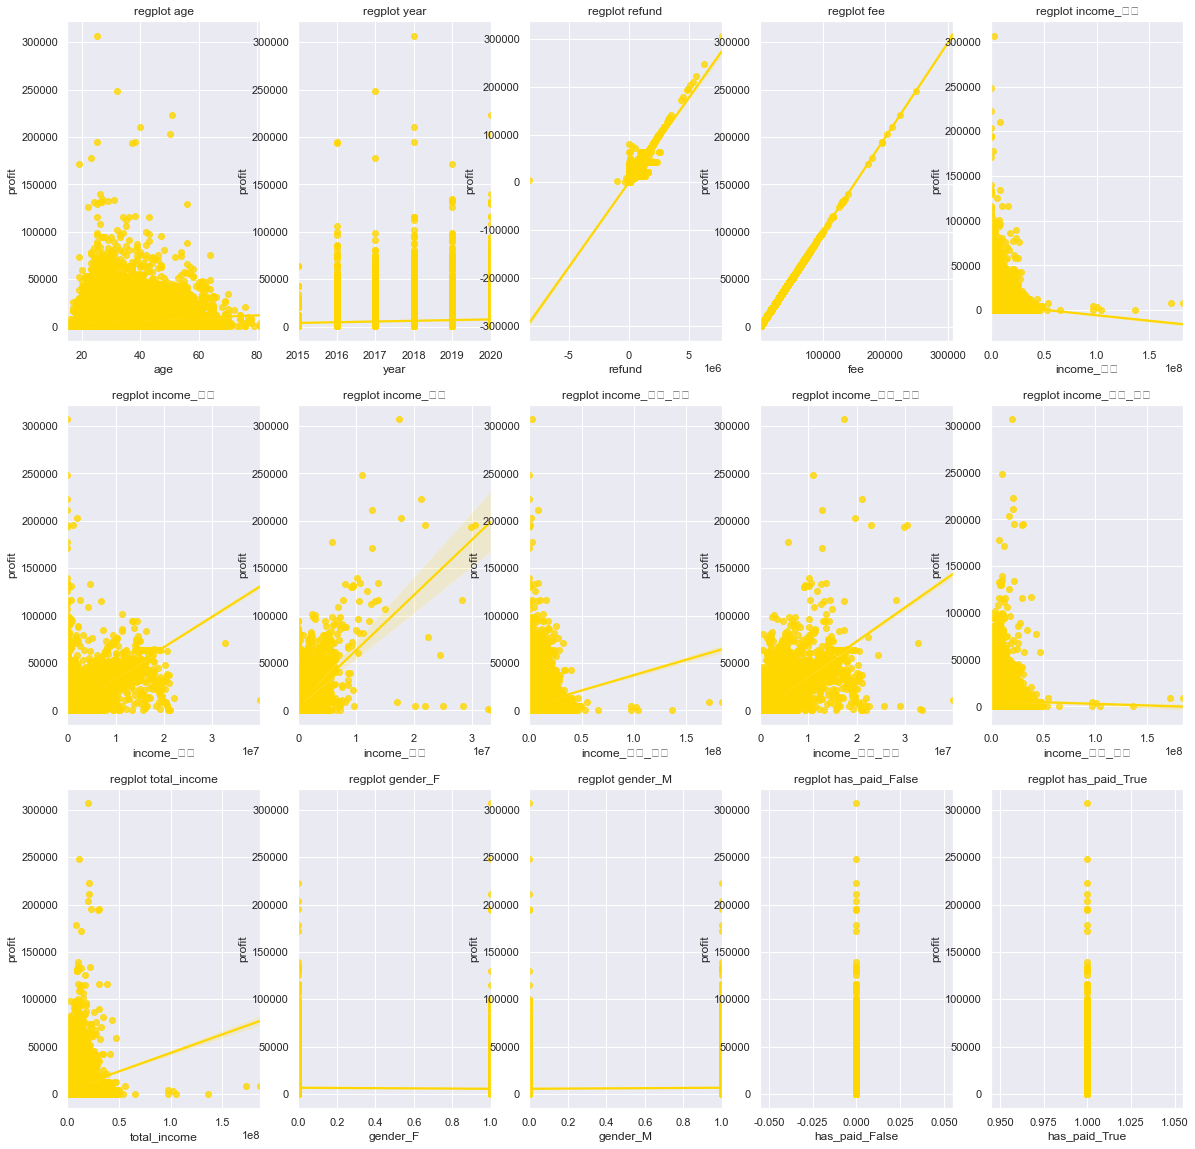

In [56]:
# 회사 수익과 다른 항목들 간의 관계를 regression plot을 통해 시각화
figure, ax_list = plt.subplots(nrows=3, ncols=5)
figure.set_size_inches(20,20)
sns.set(style="darkgrid")
for i in range(len(full_column_list2)): 
    sns.regplot(data=df3, x=full_column_list2[i], y='profit', ax=ax_list[int(i/5)][int(i%5)], color='gold') 
    ax_list[int(i/5)][int(i%5)].set_title("regplot " + full_column_list2[i])

> * 회사 수익과 수수료 사이에 1의 정비례하는 상관관계가 있기 때문에, 수수료가 증가해야 회사 수익 역시 증가함을 확인할 수 있다.

> * 회사 수익과 예상환급액 사이에 0.95의 정비례에 근접한 강한 상관관계가 있는 것을 볼 수 있다. 이는 주로 예상환급액이 많은 고객으로부터 회사 수익을 도모할 수 있음을 나타낸다.

> * 회사 수익과 고객의 사업소득 간에 0.69의 비교적 강한 상관관계, 회사 수익과 고객의 (사업+기타)소득 간에 0.79의 강한 상관관계가 있는 것으로 나타났다. 이로 미루어 볼 때, 주로 사업소득을 갖는 고객으로부터 회사 수익을 높일 수 있음을 파악할 수 있다.  

## 수수료를 결제한 고객의 비율 구하기

In [44]:
# 근로소득이 0인 고객 데이터 제외
labor_df2 = df2.loc[df2['income_근로'] > 0]
paid_labor_df2 = labor_df2.loc[labor_df2['has_paid_True']==1]
# 근로소득 고객 중 수수료를 결제한 고객의 비율
paid_labor_ratio = len(paid_labor_df2)/len(labor_df2)*100
paid_labor_ratio

69.95136869547778

In [45]:
# 사업소득이 0인 고객 데이터 제외
business_df2 = df2.loc[df2['income_사업'] > 0]
paid_business_df2 = business_df2.loc[business_df2['has_paid_True']==1]
# 사업소득 고객 중 수수료를 결제한 고객의 비율
paid_business_ratio = len(paid_business_df2)/len(business_df2)*100
paid_business_ratio

70.93386209543303

In [46]:
# 기타소득이 0인 고객 데이터 제외
extra_df2 = df2.loc[df2['income_기타'] > 0]
paid_extra_df2 = extra_df2.loc[extra_df2['has_paid_True']==1]
# 기타소득 고객 중 수수료를 결제한 고객의 비율
paid_extra_ratio = len(paid_extra_df2)/len(extra_df2)*100
paid_extra_ratio

66.03615801210576

> 수수료를 결제하는 고객 중 사업소득을 지닌 고객이 70.93%로 나머지 근로소득과 기타소득에 비해 높음을 확인할 수 있다.
    
    -> 따라서 고객의 수수료 결제금액의 합을 높이기 위해선 사업소득을 갖고 있는 고객들을 많이 유치하는 쪽으로 계획을 세우는 게 필요하다.

In [29]:
from matplotlib_venn import venn3

def venn_diagram(a, b, c, labels=['근로', '사업', '기타']):
    
    a = len(labor_df2)
    b = len(business_df2)
    c = len(df2)
    
    only_a = a-b-c
    only_b = b-a-c
    only_c = c-a-b
    
    only_a_b = a&b-c
    only_b_c = b&c-a
    only_c_a = c&a-b
    
    a_b_c = a&b&c
    
    venn3(subsets=(only_a, only_b, only_a_b, only_c, only_a_c, only_b_c, a_b_c, set_labels=labels)
          
venn_diagram(a, b, c)

SyntaxError: invalid syntax (<ipython-input-29-317b9e302e2e>, line 19)